In [411]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [413]:
import gymnasium as gym
from gymnasium.spaces import Text, MultiDiscrete, Discrete, MultiBinary, Tuple
import numpy as np
import random as rnd
import logging
from collections import namedtuple, Counter, defaultdict
import math
import csv
import pandas as pd

In [415]:

import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

import time
import logging

#https://huggingface.co/docs/transformers/en/model_doc/decision_transformer
#from transformers import DecisionTransformerConfig, DecisionTransformerModel

In [417]:
logger = logging.getLogger('root')
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [445]:
# Some basic analysis to determine strategy because a reasonable approach = combining heuristic and algorithm.
train_dict = open("words_250000_train.txt", 'r').readlines()
word_list = [word.strip() for word in train_dict]



In [421]:
#helper functions

def letter_ngrams(word, n):
    ngrams = [word[i:i+n] for i in range(len(word)-n+1)]
    return ngrams

def count_ngrams(wordlist, n):

    all_ngrams = []
    for word in wordlist:
        ngrams = letter_ngrams(word, n)
        all_ngrams.extend(ngrams)
    return Counter(all_ngrams)


def create_n_word_dictionary(words):
    """
    This function creates a dictionary where keys are word lengths and values are lists of words with that length.
    """
    n_word_dictionary = defaultdict(list)

    for word in words:
        length = len(word)
        n_word_dictionary[length].append(word)

    return n_word_dictionary

In [423]:
BIG_TRIGRAM = count_ngrams(word_list, 3)
BIG_QUADGRAM = count_ngrams(word_list, 4)
BIG_PENTAGRAM = count_ngrams(word_list, 5)

In [477]:
BIG_TRIGRAM.most_common()[-1]

('zzz', 1)

In [424]:
def compute_letter_position_probabilities(strings):
    # Dictionary to store frequencies
    position_frequencies = defaultdict(lambda: defaultdict(int))
    
    # Compute frequencies
    for s in strings:
        for position, char in enumerate(s):
            position_frequencies[position][char] += 1
    
    # Dictionary to store probabilities
    position_probabilities = defaultdict(lambda: defaultdict(float))
    
    # Compute probabilities
    for position, frequencies in position_frequencies.items():
        total_count = sum(frequencies.values())
        for char, count in frequencies.items():
            position_probabilities[position][char] = count / total_count
    
    return position_probabilities

Some basic Analysis:

In [427]:
word_count_dict = create_n_word_dictionary(word_list)

In [453]:
max_len = 0
for word in word_list:
    if len(word) > max_len :
        max_len = len(word)

#and apparently min_len is 3

In [455]:
Position_freq = {i:{} for i in range(3,max_len+1)}
for i in range(3, max_len+1):
    Position_freq[i] = compute_letter_position_probabilities(word_count_dict[i])

In [463]:
Position_freq[7][6]

defaultdict(float,
            {'l': 0.04351009711731155,
             'c': 0.01815168799136735,
             'h': 0.02289193772159704,
             'i': 0.01718822259904424,
             'r': 0.07661476799753353,
             'n': 0.08270386927701558,
             'e': 0.14101279482041004,
             'd': 0.08628796053645753,
             's': 0.1818637274549098,
             'g': 0.04293201788191768,
             'a': 0.07014028056112225,
             'y': 0.06258671188530908,
             'm': 0.020772313858486203,
             'u': 0.003969477416371204,
             't': 0.062471096038230305,
             'o': 0.023007553568675815,
             'x': 0.003738245722213658,
             'p': 0.00786187760135656,
             'f': 0.003622629875134885,
             'z': 0.0018883921689532913,
             'w': 0.005048558655773085,
             'k': 0.01896099892091876,
             'b': 0.002004008016032064,
             'q': 3.853861569292431e-05,
             'v': 0.00061661785108

In [467]:
Position_freq[7][5]

defaultdict(float,
            {'h': 0.012370895637428703,
             'i': 0.08759827347001696,
             'e': 0.21381223986434408,
             'x': 0.0006551564667797132,
             'o': 0.05765376907661477,
             't': 0.058347464159087405,
             's': 0.05179589949129027,
             'r': 0.08112378603360568,
             'a': 0.08721288731308771,
             'n': 0.10405426237089564,
             'g': 0.01834438106983197,
             'u': 0.03907815631262525,
             'l': 0.06902266070602744,
             'c': 0.02863419145984276,
             'b': 0.005318328965623555,
             'z': 0.0045475566517650685,
             'd': 0.01888392168953291,
             'k': 0.010251271774317866,
             'p': 0.008748265762293818,
             'y': 0.008709727146600893,
             'v': 0.005703715122552798,
             'f': 0.007129643903190997,
             'm': 0.015184214583012178,
             'w': 0.00474024973022969,
             'j': 0.001040542623

In [481]:
# vowel vs. consonants
def count_aeiou(dictionary):
    b05 = 0
    b = [0 for i in range(len(dictionary))]
    b045 = 0
    b055 = 0
    k =11
    for i in range(len(dictionary)):
        b[i] = sum([1 if ltr in 'aeiou' else 0 for ltr in dictionary[i]])/len(dictionary[i])
        if b[i] < 0.5 and len(dictionary[i]) == k:
            b05 += 1
        if b[i] < 0.45 and len(dictionary[i]) == k:
            b045 += 1
    print(b05/len(word_count_dict[k]),b045/len(word_count_dict[k]))
            
    return b

In [483]:
bar = count_aeiou(word_list)
# the 0.45 rule doesn't work for len <= 4 and >= 12
# 0.5 is the better threshold

0.9387343105415606 0.6033529360133415


In [485]:
import matplotlib.pyplot as plt

<BarContainer object of 29 artists>

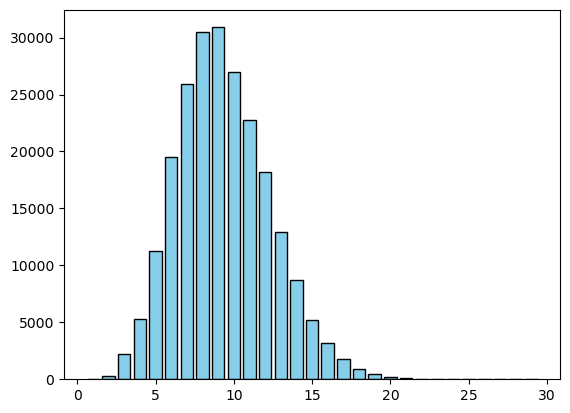

In [487]:
# word length distribution
lengths = list(word_count_dict.keys())
frequencies = [len(words) for words in word_count_dict.values()]

plt.bar(lengths, frequencies, color='skyblue', edgecolor='black')

(array([1.2490e+03, 2.0000e+00, 6.8100e+02, 1.7410e+03, 6.7780e+03,
        3.2538e+04, 3.5853e+04, 3.6370e+04, 6.0189e+04, 1.2807e+04,
        2.8992e+04, 7.8220e+03, 7.7600e+02, 1.1180e+03, 1.0800e+02,
        1.8300e+02, 5.4000e+01, 1.0000e+00, 0.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

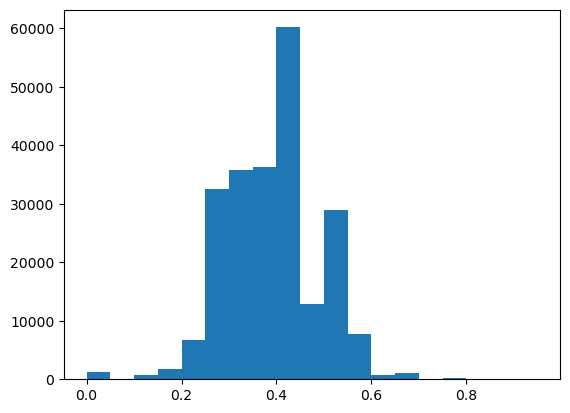

In [489]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = bar, bins = bins)

The following is the Hangman Environment that helps me run the game locally.

-------------------------------------START-------------------------------------

In [ ]:

class Config:
    """ User config class """
    def __init__(self, path: str=None): 
        
        self.model = 'qtable' #or 'transformer'
        self.lossfn = 'mse' #or 'mse'
        self.batch_size = 128
        self.learning_rate = 1e-2
        self.num_episodes = 250000
        self.mem_capacity = 10000
        self.train_steps = 999999
        self.warmup = 1000
        self.gamma = 0.95 #for the learning rate
        
        #for exploit vs explore
        self.starteps = 1
        self.endeps = 0.05
        self.decay_eps = 200
        
        self.target_update_freq = 100
        self.save_freq = 100
        self.save_file_name = 'train_01.pth'
    


In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Save aone instance of transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        return rnd.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class Hangman_Env(gym.Env):
    """Custom Hangman game Environment that follows gym interface"""
    
    metadata = {'render.modes': ['human']}
    
    def __init__(self, dict_file = None, MaxLen = 27):
        """Initialize the hangman game environment. The reason to choose digits is so that the interface can potentially be used for
        DQN, where we need input as vectors. """
        
        
        super(Hangman_Env, self).__init__()
       
        self.action_space = Discrete(26)  # the alphabet a-z = ord(x)-ord('a')
        
        self.observation_space = Tuple((
			MultiDiscrete(np.array([27]*MaxLen)),  # The state space of strings  
			MultiBinary([2]*26),# Guessed letters a-z guessed 1 unguessed 0
            Discrete(6 + 1) # attempt left = 0-6
            )) 
        #Example
        #observation 0: a___e = [0 26 26 26 4 0000000..]
        #observation 1:  only a and e are guessed [1 0 0 0 1 0000]
        #observation 2: 3 attemps are left [3]
        
        if dict_file is None:
            self.dictionary = list('no training dictionary for this game')
        else:
            f = open(dict_file, 'r').readlines()
            self.dictionary = [word.strip() for word in f]
            self.dictionary = random.sample(self.dictionary, len(self.dictionary))
        
        self.curr_word = ""
        self.unknown_word = []
        self.guessed_letters = np.zeros(26, dtype=int)
        self.attempts_left = 6
        self.win = False
        self.MaxLen = MaxLen
        
            
        self.reset()

    def reset(self, word_to_guess = None):
        """Reset the state of the environment to an initial state"""
        # Choose a random word from the list
        if word_to_guess == None:
            self.curr_word = rnd.choice(self.dictionary) 
        else:
            self.curr_word = word_to_guess
        
        self.unknown_word = ['_'] * len(self.curr_word)  # Hidden word representation
        self.guessed_letters = [0] * 26  # Initialize as all unguessed
        self.attempts_left = 6  # 6 guesses for each word
        logger.info("Reset: new word! new round!")
        logger.info("Reset: New word is [" + self.curr_word +"]")
        
        return self.get_observation()
    
    def step(self, action):
        
       assert self.action_space.contains(action), f"Invalid Action: {action} is not in the action space"
       # Just to help with debugging
       
       done = False
       reward = 0
        

       # Convert action to character
       char2guess = chr(action + ord('a'))

       # If the character was already guessed, return current state with no reward
       if self.guessed_letters[action] == 1:
           return self.get_observation(), reward, done, {}

       self.guessed_letters[action] = 1

       if char2guess in self.curr_word:
           # Correct guess
           reward = 3
           for idx, char in enumerate(self.curr_word):
               if char == char2guess:
                   self.unknown_word[idx] = char2guess
           if '_' not in self.unknown_word:
           
               done = True
               reward = 10  # Extra reward for winning
       else:
           # Incorrect guess
           reward = -1
           self.attempts_left -= 1
           if self.attempts_left == 0:
               done = True
               reward = -10  # Penalty for losing
       
        

       return self.get_observation(), reward, done, {}
    
    def get_observation(self):
        
        unknown_word_logits = [26 if char == '_' else ord(char)-ord('a') for char in self.unknown_word]
        padding = [-1]*(self.MaxLen-len(unknown_word_logits))
        # 1 =  know 0 = unknown
        return torch.tensor(unknown_word_logits+padding), torch.tensor(self.guessed_letters), self.attempts_left, {}
    
    
    def render(self, mode='human'):
        unknown_word_str = " ".join(self.unknown_word)
        guessed_letters_str = ", ".join([chr(i + ord('a')) for i, val in enumerate(self.guessed_letters) if val == 1])
        print(f"Word: {unknown_word_str}")
        print(f"Guessed Letters: {guessed_letters_str}")
        print(f"Attempts Left: {self.attempts_left}")
        
        

----------------------------------------------------------------------------------------------------------------------------------

A Class to create n-gram. Potentially Useful in statistical approach.
The class can create and calculate the probablity distribution provided by 1-5 grams.

In [ ]:
class n_gram():
    '''
    Classic statistic method in case for the love of God NN isn't the best suit.
    Also can be used to help with training the RL agent.
    '''
    

    def __init__(self, dictionary, list_to_exclude = []):
        
        self.full_dict = dictionary #give me a list
        self.dict_clean_up(list_to_exclude)
    
        self.unigram = count_ngrams(self.full_dict, 1)
        self.gram = {}
        

    def dict_clean_up(self, list_to_exclude):
        '''
        input = a list of letters
        re-create everything excluding the letter that we don't want.
        '''
        full = self.full_dict
        new_dict = []
        for word in full:
            logit = sum([1 if l in word else 0 for l in list_to_exclude])
            if logit == 0:
                new_dict.append(word)
                
        self.full_dict = new_dict
                
    


    def make_grams(self, n):

        self.gram = count_ngrams(self.full_dict, n)


        
    def get_slice(self, word_state, slice_len):
        '''
        get the pattern around the blank words
        '''
        count = len(word_state)
        slice = []

        
        for i in range(count-slice_len):
    
            if 26 in word_state[i:i+slice_len]:
                s = word_state[i:i+slice_len]
                st = ''
                flag = 0
                for n in s:
                    if n == 26 and s!=[26]*slice_len:
                        flag = 1
                        st += '.'
                    else:
                        st += chr(n+ord('a'))
                if flag:
                    slice.append(st)
                
        return slice

    def unigram_probability(self, word_state):
        '''
        basically a frequency count
        '''
        uni_p = [0 for i in range(26)]
        
        for letter, freq in self.unigram.items():
   
            uni_p[ord(letter)-ord('a')] = freq
        uni_p = np.array(uni_p)/sum(uni_p)

    
    def ngram_probability(self, n, word_state):
        
        freq_dict = {}
        for letter in 'abcdefghjiklmnopqrstuvwxyz':
            freq_dict[letter] = 0

        if n > 1:
            self.make_grams(n)
        # 2
            bi_p = [0 for i in range(26)]
            slice = self.get_slice(word_state, n)
            matches = {}
            compiled_patterns = [re.compile(pattern) for pattern in slice]
            for pattern in compiled_patterns:
                for gram, count in self.gram.items():
                    if pattern.match(''.join(gram)):
                        matches[gram] = count
                        
            for keys in matches:
                for i in 'abcdeklmnfghijopqrstuvwxyz':
                    if i in keys:
                        freq_dict[i] += matches[keys]
                        bi_p[ord(i)-ord('a')] += matches[keys]
            bi_p = np.array(bi_p)/(sum(bi_p) + 1e-9)
            return bi_p, {key: freq_dict[key] for key in sorted(freq_dict)}
        #print(matches)

        
        else:
            print('only support 2 - ')

In [479]:

class Q_hangman():
    '''
    The hangman agent. for Q-table based learning.
    '''
    
    def __init__(self):

        en = Hangman_Env(dict_file = "words_250000_train.txt")
        self.config = Config() #alpha beta gamma batch_size
        self.state_size = 27
        self.action_size = 26
        self.memory = ReplayMemory(self.config.mem_capacity)
        self.step_count = 0
        self.episode_durations = []
        self.last_episode = 0
        self.reward_in_episode = []

        self.env = en
        self.id = int(time.time())
        self.checkpoint = 0
        self.win = 0
        self.lose = 0
        
        # Fast and Easy
        if self.config.model == 'qtable':
            self.policy_net = defaultdict(lambda: np.zeros(26))

    def reset_counter(self):
        self.win = 0
            
    
    def eps_scheduler(self):
        '''
        Adaptively balance explore or exploit, using exponential decay
        '''
        
        return self.config.endeps + (self.config.starteps - self.config.endeps)*math.exp(-1. * self.step_count / self.config.decay_eps/1000)
     

           
            
    def heuristic_action(self, state):

        #letter_frequencies = 'etaoinshrdlcumwfgypbvkjxqz'
        if rand > 2: #change this depending on DQN or just Qtable
            select = rnd.choice([i for i in range(26)])
            while guessed[select] == 1:
                select = rnd.choice([i for i in range(26)])
            return select

        

    def correct_letter(self,state):
        correct = []
        state = state[0:27]
        for i in state:
            if 0<=i<=25:
                correct.append(chr(i+ord('a')))
        return correct


    def state2wrd(self, state):
        '''
        Helper function to switch between state and words.
        '''
        
        pattern = ''
        for logit in state:
            if logit == 26:
                pattern += '_'
            elif logit == -1:
                pattern += '*'
            else:
                pattern += chr(logit+ord('a'))

        return pattern
        

    def word2state(self, word):

        state = [0 for i in range(27)]
        idx = 0
        for w in word:
            if w == '_':
                state[idx] = 26
            elif word == '*':
                state[idx] = -1
            else:
                state[idx] = ord(w) -ord('a')
            idx += 1

        return torch.tensor(state)
            
                


    def act_stat(self, state):
        '''
        Statistical method. 1# to provide instances for RL. 2# RL may not be a good approach for this problem.
        '''

        # find length
        l = len(self.env.curr_word)

        #dictionary of words with fixed length
        dictionary = word_count_dict[l] #n-dictionary created outside the function.

        #--------------------Potentially useful------------------------------------
        guessed = [chr(idx + ord('a')) for idx in range(26) if self.env.guessed_letters[idx] == 1]
        correct = self.correct_letter(state)
        wrong = list(set(guessed)-set(correct))
        countobs = sum([1 if k==26 else 0 for k in state])
        # The positions of the unguessed words
        obs_pos = []
        for i in range(l):
            if state[i] == 26:
                obs_pos.append(i)
        vowel_idx = [0,4,8,14,20]
        vowel_count = sum([1 if state[idx] in [0,4,8,14,20] else 0 for idx in range(27)])
        guess_vowel = vowel_count/l < 0.55 #test against 0.5 and 0.45


        
        pattern = ''
        for logit in state:
            if logit == 26:
                pattern += '.'
            elif logit == -1:
                pass
            else:
                pattern += chr(logit+ord('a'))
                
        #dictionary from substrings all all words
        pattern_match_dict = []
        for wrd in dictionary:
            # match pattern
            if re.match(pattern,wrd):
                pattern_match_dict.append(wrd)
        
        N_gram = n_gram(pattern_match_dict) 
        unigram = N_gram.unigram.most_common()
      
        #nothing is done if action = -1
        action = -1
            
        for letter, freq in unigram:
            if letter not in guessed:
                code = ord(letter)-ord('a')
                if code in vowel_idx and not guess_vowel: 
                    #action = code
                    continue
                action = code
                break
   
   
        # Substring dictionaries
        if action  == -1:
       
            substring_dict = self.sub_dictionary(word_list, pattern)
            l_gram = n_gram(substring_dict) 
            l_unigram = l_gram.unigram.most_common()
       
            for letter, freq in l_unigram:
                if letter not in guessed:
                    code = ord(letter)-ord('a')
                    if code in vowel_idx and not guess_vowel:
                        #action = code
                        continue
                    action = code
                    break
                    
        '''
        if action  == -1:
       
            k = 5
            subsubstring_dict = []
            for idx in range(l-k+1):
                subpattern = pattern[idx:idx+k]
                subsubstring_dict += self.sub_dictionary(word_list, subpattern)
            
            l_gram = n_gram(subsubstring_dict) 
            l_unigram = l_gram.unigram.most_common()
    
            for letter, freq in l_unigram:
                if letter not in guessed:
                    code = ord(letter)-ord('a')
                    action = code
                    
        
        if action  == -1:
       
            k = 3
            subsubstring_dict = []
            for idx in range(l-k+1):
                subpattern = pattern[idx:idx+k]
                subsubstring_dict += self.sub_dictionary(word_list, subpattern)
            
            l_gram = n_gram(subsubstring_dict) 
            l_unigram = l_gram.unigram.most_common()
    
            for letter, freq in l_unigram:
                if letter not in guessed:
                    code = ord(letter)-ord('a')
                    action = code
        '''
        # N-gram based parts are not used in training because it hinders the efficiency too much.
        # Computational complexity.

        if action == -1:
  
            sorted_frequency_full = dictionary_frequency #already computed before hand to save time
    
                #largest_k_elements = arr[largest_k_indices]
            for letter, freq in sorted_frequency_full:
                if letter not in guessed:
                    action = ord(letter) - ord('a')
                    
        return action
            
                

    def act_q(self, state, for_test = False):
        '''
        Select an action. This is the function to call when playing the game.
        For the classical reinforcement Q-table learning.
        '''
        
        sample = rnd.random()
        eps = self.eps_scheduler()
        if for_test:
            eps = 0.2
        self.step_count += 1
        countobs = sum([1 if k==26 else 0 for k in state])
        
        
        vowel_idx = [0,4,8,14,20]
        vowel = sum([1 if self.env.guessed_letters[idx]== 1 else 0 for idx in [0,4,8,14,20] ])
        

        
        #Use eps to control exploit vs explore. The stat approach provides extra correct updates to the Q table
        if sample > eps and self.state2wrd(state) in self.policy_net: #exploit
            
            #print('exploit')
            #print(self.policy_net[self.state2wrd(state)])
            action = self.policy_net[self.state2wrd(state)].argmax()
    
            if self.env.guessed_letters[action] == 0:
                 
                return action
            else:
              
                LST = [i for i in range(26)]
                select = rnd.choice(LST)
                while self.env.guessed_letters[select] == 1:
                    LST.remove(select)
                    select = rnd.choice(LST)
                action = select
     
        elif eps > sample > 1/2*eps:
    
            selected_action = self.act_q(state)
            action = selected_action
        else: #explore, using heuristic
            LST = [i for i in range(26)]
            select = rnd.choice(LST)
            while self.env.guessed_letters[select] == 1:
                LST.remove(select)
                select = rnd.choice(LST)
            action = select

        return action                    
            
    def q_table_update(self, state, action, reward, next_state):

        state = self.state2wrd(state)
        next_state = self.state2wrd(next_state)
        
        best_next_action = np.argmax(self.policy_net[next_state])
        td_target = reward + self.config.gamma * self.policy_net[next_state][best_next_action]
        td_error = td_target - self.policy_net[state][action]
        self.policy_net[state][action] += self.config.learning_rate * td_error


    def train_q_table(self):
        '''
        for the non-nn method. no replay neede. how nice.
        '''

        num_episodes = self.config.num_episodes
        self.episode_durations = []
        self.reward_in_episode = []
        reward_in_episode = 0
        for epi_idx in range(num_episodes):
            # episode start. Initiate env.
            state = self.env.reset()
           
            #guessed_letters = state[1]
            #attempleft = state[2]
            state = state[0]
          
            count = -1
            while True:
                count += 1
                # Select an action
                action = self.act_stat(state)
          
                next_state, reward, done, _ = self.env.step(int(action))
                if reward > 10:
                    self.win += 1
                next_state = next_state[0]

                self.q_table_update(state, action, reward, next_state)


                done = (count > 28) or done
                
                # Move to the next state
                state = next_state
                reward_in_episode += reward

                if epi_idx % 1 == 0:
                    print('episode', epi_idx)
                    self.env.render()
                    #print(self.eps_scheduler())
            

                if done:
                    self.episode_durations.append(count + 1)
                    self.reward_in_episode.append(reward_in_episode)
                    reward_in_episode = 0
                    break


                self.last_episode = epi_idx

                if done:
                    self.episode_durations.append(count + 1)

                    break
                    
            if epi_idx % 100 == 0:
                    
                    self.save()
                    #print(self.eps_scheduler())
    

    def sub_dictionary(self, full_dict, word_pattern):
        '''
        create a subdictionary for high-quality prediction.
        '''
        
        full_dict
        new_dictionary = []
        l = len(word_pattern)
        for dict_word in full_dict:
            for i in range(len(dict_word)-l):
                if re.match(word_pattern,dict_word[i:i+l]):
                    new_dictionary.append(dict_word[i:i+l])
        return new_dictionary


    
    def get_Q_table(self):

        return self.policy_net


    def save(self):
        filename = 'q_table_' + str(self.checkpoint) + '.csv'
      
        data = {key: value.tolist() for key, value in self.policy_net.items()}
        table = pd.DataFrame(self.policy_net)

        table.to_csv(filename,index=False)

        
        
        
        
        

    def load(self, checkpoint = 0):
        filename = 'q_table_' + str(checkpoint) + '.csv'

        table = pd.read_csv(filename, index_col=None)

        data = table.to_dict()
        table = {key: np.array(list(value)) for key, value in data.items()}
    
        self.policy_net.update(table)
        self.checkpoint = checkpoint
      

        

    
        

In [400]:
# Let's first trained this askdjhg!@(*&asd with the 'word_250000_train_txt' 
train_instance = Q_hangman()
train_instance.load()


In [401]:
train_instance.train_q_table()

episode 0
Word: _ e _ _ e _ _ _ _ _ _
Guessed Letters: e
Attempts Left: 6
episode 0
Word: _ e _ r e _ _ _ _ _ _
Guessed Letters: e, r
Attempts Left: 6
episode 0
Word: _ e _ r e t _ _ _ _ _
Guessed Letters: e, r, t
Attempts Left: 6
episode 0
Word: _ e _ r e t _ _ _ a _
Guessed Letters: a, e, r, t
Attempts Left: 6
episode 0
Word: _ e c r e t _ _ _ a _
Guessed Letters: a, c, e, r, t
Attempts Left: 6
episode 0
Word: _ e c r e t i _ _ a _
Guessed Letters: a, c, e, i, r, t
Attempts Left: 6
episode 0
Word: s e c r e t i _ _ a _
Guessed Letters: a, c, e, i, r, s, t
Attempts Left: 6
episode 0
Word: s e c r e t i o _ a _
Guessed Letters: a, c, e, i, o, r, s, t
Attempts Left: 6
episode 0
Word: s e c r e t i o n a _
Guessed Letters: a, c, e, i, n, o, r, s, t
Attempts Left: 6
episode 0
Word: s e c r e t i o n a l
Guessed Letters: a, c, e, i, l, n, o, r, s, t
Attempts Left: 6
episode 1
Word: _ _ _ _ _ _ _ _ _ _ e
Guessed Letters: e
Attempts Left: 6
episode 1
Word: _ _ _ _ _ _ _ i _ _ e
Guessed Lette

attached is a potential model for hangman DQN. 1D convolution layer for pattern extraction, followed by LSTM.

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_size=27, action_size=26):
        ''' A potential model for Hangman DQN
        '''
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size+action_size+1, 32)
        self.conv = nn.Conv1d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.lstm = nn.LSTM(12*32, 12*32,  batch_first=True)
        
        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(3*32, action_size)

    def initialize_weights(self):
        # Initialize fully connected layers using Xavier initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    
    def forward(self, x):
        
        x = torch.relu(self.fc1(x))
        x = self.conv (x.reshape(-1,1,32))
        x, _ = self.lstm(x.reshape(-1,1,12*32))
        x = self.fc2(x.squeeze(0))

        return x

In [ ]:
#helper functions such that the functions can be directly allied 

def to_guessed_letter(letterlist):
    ''' change self.guessed_letters
    '''
    ls = [0 for i in range(26)]
    for l in letterlist:
        ls[ord(l)-ord('a')] = 1
    return ls


def to_state(word):
    ls = [-1 for i in range(max(len(word),27))] 
    idx = 0
    for k in word:
        if k not in 'abcdefghijklmnopqrstuvwxyz':
            ls[idx] = 26
        else:
            ls[idx] = ord(k)-ord('a')
        idx += 1
    #shape torch.size([])
    return ls[0:27]
